In [1]:
import xarray as xr
import fsspec
import xarray as xr
from kerchunk.grib2 import scan_grib
from pathlib import Path
import ujson
import json
import fsspec
import glob

In [3]:
fs = fsspec.filesystem('file')

In [4]:
flist = fs.glob('gfs*')
flist = [f for f in flist if f not in fs.glob('*.idx')]

In [5]:
#generate a json from a netCDF
def gen_json(u):
    #open the file (u) with desiganted parameters (so), call it infile
    with fs.open(u, **so) as infile:
        #inline_threshold: chunks smaller than 300 (I'm guessing mb?) are included in output
        h5chunks = scan_grib(f, common_vars = ['time', 'step', 'latitude', 'longitude', 'valid_time'], storage_options=so)
        #Path().stem is from the pathlib library; returns the file name w/o the extension
        fstem = Path(u).stem
        #here we create the output file path
        outf = f'{json_dir}/{fstem}.json'
        #print(outf)
        #wb: write binary file
        with fs.open(outf, 'wb') as f:
            #create json file and write it to the path specified above (f)
            #dumps: dictionary to string
            #translate: translate contents of HDF5 to Zarr
            f.write(ujson.dumps(h5chunks.translate()).encode());

In [6]:
so = dict(mode='rb')
so = {"anon": True, "default_cache_type": "readahead"}

In [7]:
for f,i in zip(flist, range(len(flist))):
    print(f)
    outscan = scan_grib(f, common_vars = ['time', 'step', 'latitude', 'longitude', 'valid_time'], storage_options=so)
    with open(str(i)+'.json', "w") as outfile:
        outfile.write(json.dumps(outscan))

/home/peter/Documents/kerchunk_experiment/gfs/gfs.t06z.pgrb2.0p25.f000
/home/peter/Documents/kerchunk_experiment/gfs/gfs.t06z.pgrb2.0p25.f001


In [40]:
json_list = glob.glob('*.json')
#json_list = sorted(json_list)

In [41]:
json_list

['0.json', '1.json']

In [51]:
rpath = json_list[0]

In [53]:
fs3 = fsspec.filesystem("reference", fo=rpath)

In [54]:
fs3

In [58]:
m = fs3.get_mapper("")
ds = xr.open_dataset(m, engine="zarr",chunks={}, backend_kwargs={'consolidated':False})

In [89]:
ds

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 nan 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables: (12/79)
    4lftx       (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    SUNSD       (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    VRATE       (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    absv        (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    aptmp       (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    cape        (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    ...          ...
    vis         (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    vstm        (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    vwsh        (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    w           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    wilt        (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    wz          (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_edition:            2
    GRIB_subCentre:          0
    history:                 2022-04-18T09:59 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             US National Weather Service - NCEP

In [86]:
t = ds.t.load()

In [87]:
t = t.dropna(dim = 'latitude').dropna(dim = 'longitude') # 0 longitude represented as nan for some reason

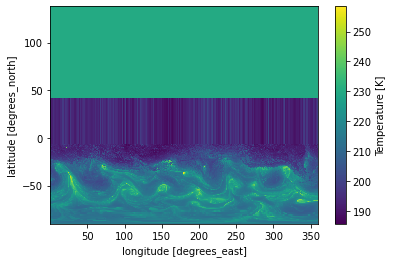

In [88]:
t[:,1:].plot() #Again something not correct here